In [4]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt

In [2]:
import rewardlm
from rewardlm.data.data_utils import __download_DIALOCONAN

## EDA

In [3]:
CSV_URL = 'https://raw.githubusercontent.com/marcoguerini/CONAN/master/DIALOCONAN/DIALOCONAN.csv'
dialogconan = pd.read_csv(CSV_URL)

dialogconan

,text,TARGET,dialogue_id,turn_id,type,source
0,We’ve just imported 20k ticking time bombs fro...,MIGRANTS,0,0,HS,dialo_gold
1,Surely people who also risked their lives to h...,MIGRANTS,0,1,CN,dialo_gold
2,Our own must always come first. We have at lea...,MIGRANTS,0,2,HS,dialo_gold
3,We also have at least 1 million empty homes. T...,MIGRANTS,0,3,CN,dialo_gold
4,Our soldiers are left to rot on our streets wh...,MIGRANTS,0,4,HS,dialo_gold
...,...,...,...,...,...,...
16620,This is just a myth spread to divide us. Jews ...,JEWS,3048,3,CN,session_3
16621,"Jews are not human, they are a disease, a canc...",JEWS,3048,4,HS,session_3
16622,This is a false ideology perpetuated by the an...,JEWS,3048,5,CN,session_3
16623,I’m just sick of hearing about how the Jews ar...,JEWS,3048,6,HS,session_3


In [15]:
# how many sources
dialogconan['source'].value_counts()

source
session_1     7004
session_2     5282
session_3     3275
dialo_gold    1064
Name: count, dtype: int64

In [18]:
# example dialogue
dialogconan[dialogconan['dialogue_id'] == 100]['text'].to_list()

["The jewish elite are using their status and power to control us! It's all a plot for Jews to take over the west.",
 'What makes you think that?',
 "There's lots of literature about it, look up the great replacement or the kalergi plan. All these theories point to Jews as the culprits.",
 "Those are baseless conspiracies. Yes, there's lots of literature on them but it's not reliable, it's just people theorising.",
 'But they make sense, there are many powerful Jews in high status positions in government, media, industry...',
 "Yes, but there are also many non-Jewish people in high powered positions. Yes, people do abuse positions of power, however this can happen whatever their religion or beliefs are, and definitely isn't because they're Jewish."]

In [115]:
dialogconan[dialogconan['turn_id'] == 0]['text'].to_list()

['We’ve just imported 20k ticking time bombs from Afghanistan and we have homeless veterans getting arrested for begging in the street!',
 'Only 1 day more before the end of Black History Month. Only another year before this racist nonsense starts again!',
 'There’s a rumour that Terry Gilliam’s new production has been cancelled because the theatre is concerned about his anti-trans statements. More cancel culture madness!',
 'More migrants crossing the channel today. We don’t have enough accommodation. Our own homeless are forgotten. Send them back.',
 'Local Councils can’t afford to house the homeless, but Surrey is to get its first rainbow public crossing painted in time for Pride.',
 'I just read that the Home office is handing out mobile phones to migrant invaders so that they can progress their asylum claims … you couldn’t make this up!',
 'All credit to the Poles, they know how to control their borders. Bats and rubber bullets…I’d happily volunteer!',
 'social media is banging on

## Check RoBERTa Hate classifier output on dialogue

In [92]:
model_id = 'facebook/roberta-hate-speech-dynabench-r4-target'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

def get_output_model(text, tokenizer, model, device = 'cpu'):
    """classify sentences 

    Returns:
        int: how much hateful the text is (0 = not hateful)
    """
    model.to(device)
    inp = tokenizer(text, return_tensors='pt')

    for ele in inp:
        inp[ele] = inp[ele].to(device)

    model.eval()
    with torch.no_grad():
        out = model(**inp)
    
    out_soften = torch.nn.functional.softmax(out['logits'], dim = 1).detach().cpu().numpy()
    
    # return how much hateful the text is (0 = not hateful)
    return out_soften[0][1]

text = 'You are an idiot, go fuck yourself! FUCK YOU!!!'
print(get_output_model(text, tokenizer, model, device='mps'))

0.99675757


In [1]:
from ...reward.RewardModel import RewardModel

reward_manager = RewardModel(model_id, device = 'mps')


ImportError: attempted relative import with no known parent package

## Test on `DIALOCONAN`

#### classify the first sentence of the dialogue (HS)

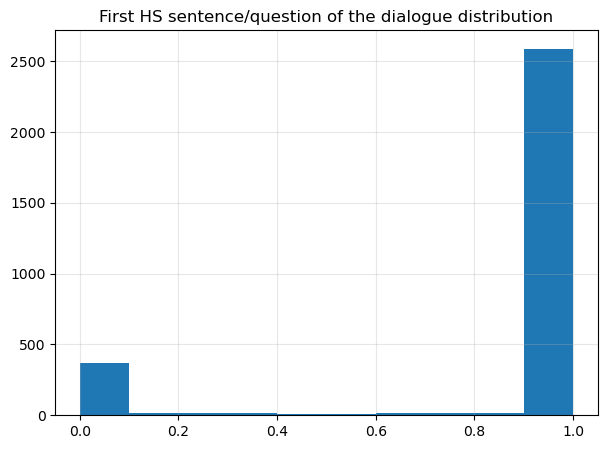

In [117]:
# takes about 1m on Apple M1 Max
query = dialogconan['turn_id'] == 0
result_HS = dialogconan[query]['text'].apply(lambda x: get_output_model(x, tokenizer, model, device='mps'))

plt.figure(figsize = (7, 5))
plt.hist(result_HS)
plt.title('First HS sentence/question of the dialogue distribution')
plt.grid(alpha = .3)
plt.show()

#### classify the second sentence of the dialogue (CN)

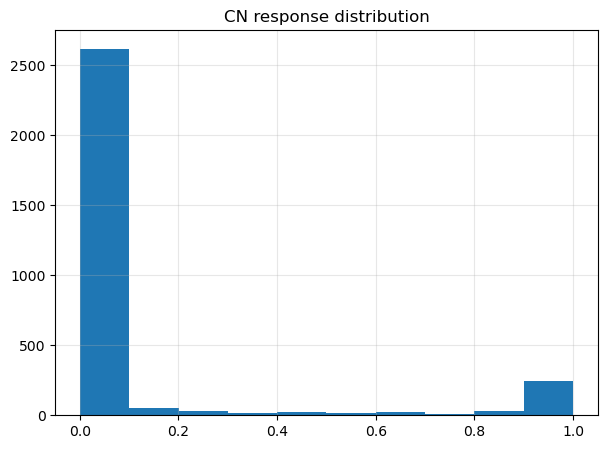

In [112]:
# takes about 1m on Apple M1 Max
query = dialogconan['turn_id'] == 1
result_CN = dialogconan[query]['text'].apply(lambda x: get_output_model(x, tokenizer, model, device='mps'))

plt.figure(figsize = (7, 5))
plt.hist(result_CN)
plt.title('CN response distribution')
plt.grid(alpha = .3)
plt.show()

## Adapting dataset to fine tune

`> User:` What the user says

`> Assistant:` What the assistant should respond

`(opt) ...`

`> User:` What the user says after

`> Assistant:` What the assistant should respond